In [1]:
import os
import json
import pandas as pd
import numpy as np
from tqdm import tqdm
import torch
import kagglehub
import random
import matplotlib.pyplot as plt
import json
np.random.seed(42)

# Dataset

In [ ]:
#@title Download from Kaggle
path = "/root/.cache/kagglehub/datasets/himanshuwagh/spotify-million/versions/1"
if not os.path.exists(path):
  path = kagglehub.dataset_download("himanshuwagh/spotify-million")

data: str = os.path.join(path, "data")

Download already complete (5585657586 bytes).
Extracting files...


In [3]:
#@title Shuffle Dataset
shuffled_slices = np.array(os.listdir(data))
np.random.shuffle(shuffled_slices)

## Data Visualization & Handling

In [4]:
million_df = pd.DataFrame()

data_list = []

for i, filename in tqdm(enumerate(shuffled_slices[:100]), desc="Processing Slices", total = len(shuffled_slices[:100])):
    if filename.startswith("mpd.slice.") and filename.endswith(".json"):
        filepath = os.path.join(data, filename)

        with open(filepath, "r", encoding="utf-8") as jsonfile:
            cur_slice = json.load(jsonfile)

        for playlist in cur_slice["playlists"]:
            playlist_id = playlist["pid"]

            for track in playlist["tracks"]:
                data_list.append({
                    "playlist": playlist_id,
                    "track": track["track_uri"][14:]
                })

    if i%50 == 0:
        new_data = pd.DataFrame(data_list)
        data_list.clear()
        million_df = pd.concat([million_df, new_data], ignore_index=True)

new_data = pd.DataFrame(data_list)
data_list = []
million_df = pd.concat([million_df, new_data], ignore_index=True)

million_df["playlist"] = million_df["playlist"].astype("int32")
million_df.drop_duplicates(inplace=True)

Processing Slices:  83%|████████▎ | 500/600 [04:37<00:55,  1.80it/s]


In [5]:
million_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 32744921 entries, 0 to 33183715
Data columns (total 2 columns):
 #   Column    Dtype 
---  ------    ----- 
 0   playlist  int32 
 1   track     object
dtypes: int32(1), object(1)
memory usage: 624.6+ MB


In [6]:
million_df.shape

(32744921, 2)

In [7]:
million_df.head

<bound method NDFrame.head of           playlist                   track
0           471000  6sW6EvagT9ljwokJlG6obt
1           471000  6SFbRVZMfbLsXHXc7JqzRs
2           471000  2VBluJiNj9bKohWX0dY1Lh
3           471000  3AX4HIRJY6GT6tgMkO5987
4           471000  07isIbQefUUFa28iA0dzHR
...            ...                     ...
33183711     59999  3CgonfeyRh23O9F4aKiIbW
33183712     59999  32kv5RvAMzTDSAdcBpw8SZ
33183713     59999  0JxI0r0gooV71qlPfHqJry
33183714     59999  5uZLsGY9fknBd5Rxr7AIss
33183715     59999  3xKTpGCsafXzV4muM1Hpl3

[32744921 rows x 2 columns]>

<Axes: xlabel='Tracks', ylabel='Log Number of Playlist'>

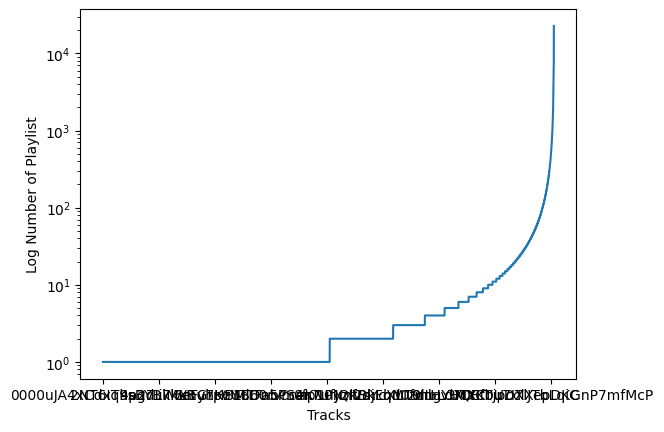

In [8]:
# @title In how many playlists does each track appear?
million_df.groupby("track")["playlist"].nunique().sort_values().plot(logy=True, ylabel="Log Number of Playlist", xlabel="Tracks") # .plot(kind="hist", bins=50, )

In [9]:
track_counts = million_df.groupby("track")["playlist"].nunique()
# use only songs that appear in at least 25 playlists
min_playlist_num = 25
max_playlist_num = np.inf
valid_tracks = track_counts[(track_counts >= min_playlist_num) & (track_counts <= max_playlist_num)]

In [10]:
print(f"Number of Tracks goes from {track_counts.shape[0]} to {valid_tracks.shape[0]} (Ratio of {(valid_tracks.shape[0]/track_counts.shape[0])*100:.2f}%)")

Number of Tracks goes from 1610128 to 119024 (Ratio of 7.39%)


In [11]:
print(f"Before removing tracks: {million_df.shape = }")
million_df = million_df[million_df["track"].isin(valid_tracks.index)]
print(f"After removing tracks: {million_df.shape = }")

Before removing tracks: million_df.shape = (32744921, 2)
After removing tracks: million_df.shape = (28099207, 2)


<Axes: xlabel='Number of Tracks', ylabel='Number of Playlists'>

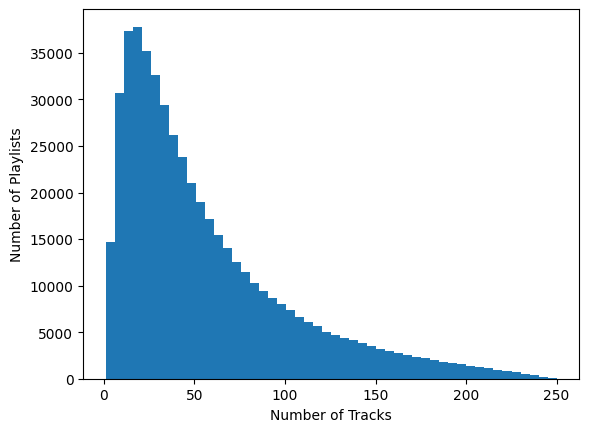

In [12]:
# @title How many playlists share the same number of tracks, and how many tracks are in them?
million_df.groupby("playlist")["track"].nunique().plot(kind="hist", bins=50, ylabel="Number of Playlists", xlabel="Number of Tracks")  # .sort_values().plot()

In [13]:
playlist_counts = million_df.groupby("playlist")["track"].nunique()
# use only playlists with more than 10 tracks and less than 150
min_track_num = 10
max_track_num = 150
valid_playlists = playlist_counts[(playlist_counts >= min_track_num) & (playlist_counts <= max_track_num)]

In [14]:
print(f"Number of Playlists goes from {playlist_counts.shape[0]} to {valid_playlists.shape[0]} (Ratio of {(valid_playlists.shape[0]/playlist_counts.shape[0])*100:.2f}%)")


Number of Playlists goes from 497153 to 428039 (Ratio of 86.10%)


In [15]:
print(f"Before removing playlists: {million_df.shape = }")
million_df = million_df[million_df["playlist"].isin(valid_playlists.index)]
print(f"After removing playlists:  {million_df.shape = }")

Before removing playlists: million_df.shape = (28099207, 2)
After removing playlists:  million_df.shape = (22248472, 2)


# Language Model Approach

In [ ]:
# Convert the dataframe in the dataset for the LM
playlists = dict()
for playlist, track in zip(million_df["playlist"], million_df["track"]):
    if playlist not in playlists:
        playlists[playlist] = []
    playlists[playlist].append(track)

In [ ]:
unique_tracks = set(million_df["track"])
stoi = {track: i+1 for i, track in enumerate(sorted(unique_tracks))}
stoi['.'] = 0
itos = {i: track for track, i in stoi.items()}
vocab_size = len(itos)
print("Vocab size:", vocab_size)

In [ ]:
# --- Creazione del dataset per il language model ---
block_size = 5  # lunghezza del contesto
X_data, Y_data = [], []
for playlist in playlists.values():
    context = [0] * block_size  # inizializziamo il contesto con il token di stop
    # Aggiungiamo il token di stop alla fine della playlist
    for track in playlist + ['.']:
        ix = stoi[track]
        X_data.append(context.copy())
        Y_data.append(ix)
        # Aggiorniamo il contesto: shift a sinistra e aggiungiamo l'indice corrente
        context = context[1:] + [ix]

X = torch.tensor(X_data, dtype=torch.long)
Y = torch.tensor(Y_data, dtype=torch.long)
print("Dataset shape:", X.shape, Y.shape)

In [ ]:
# --- Suddivisione train/val/test ---
indices = torch.randperm(X.shape[0])
X = X[indices]
Y = Y[indices]
n_total = X.shape[0]
n_train = int(0.8 * n_total)
n_val   = int(0.1 * n_total)

Xtr, Ytr = X[:n_train], Y[:n_train]
Xval, Yval = X[n_train:n_train+n_val], Y[n_train:n_train+n_val]
Xte, Yte = X[n_train+n_val:], Y[n_train+n_val:]
print("Training samples:", Xtr.shape[0])
print("Validation samples:", Xval.shape[0])
print("Test samples:", Xte.shape[0])

In [ ]:
# --- Definizione del modello ---
class PlaylistModel(nn.Module):
    def __init__(self, vocab_size, n_embd, block_size, n_hidden):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, n_embd)
        self.block_size = block_size
        self.mlp = nn.Sequential(
            nn.Linear(n_embd * block_size, n_hidden, bias=False),
            nn.BatchNorm1d(n_hidden),
            nn.Tanh(),
            nn.Linear(n_hidden, n_hidden, bias=False),
            nn.BatchNorm1d(n_hidden),
            nn.Tanh(),
            nn.Linear(n_hidden, n_hidden, bias=False),
            nn.BatchNorm1d(n_hidden),
            nn.Tanh(),
            nn.Linear(n_hidden, n_hidden, bias=False),
            nn.BatchNorm1d(n_hidden),
            nn.Tanh(),
            nn.Linear(n_hidden, n_hidden, bias=False),
            nn.BatchNorm1d(n_hidden),
            nn.Tanh(),
            nn.Linear(n_hidden, vocab_size, bias=False),
            nn.BatchNorm1d(vocab_size)
        )
        # Riduciamo la scala del layer BN finale
        final_bn = self.mlp[-1]
        final_bn.weight.data.mul_(0.1)
    
    def forward(self, x):
        emb = self.embedding(x)                   # -> (batch_size, block_size, n_embd)
        emb = emb.view(emb.size(0), -1)             # -> (batch_size, block_size * n_embd)
        logits = self.mlp(emb)                      # -> (batch_size, vocab_size)
        return logits



In [ ]:
n_embd = 100
n_hidden = 100
model = PlaylistModel(vocab_size, n_embd, block_size, n_hidden).to(device)
print("Numero di parametri:", sum(p.numel() for p in model.parameters()))



In [ ]:
# --- Ottimizzatore e DataLoader ---
batch_size = 64
train_dataset = TensorDataset(Xtr, Ytr)
val_dataset   = TensorDataset(Xval, Yval)
test_dataset  = TensorDataset(Xte, Yte)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size)
test_loader  = DataLoader(test_dataset, batch_size=batch_size)

optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
numb_step_change = 1500

@torch.no_grad()
def evaluate_loss(loader):
    model.eval()
    total_loss = 0.0
    total_samples = 0
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)
        logits = model(xb)
        loss = F.cross_entropy(logits, yb, reduction='sum')
        total_loss += loss.item()
        total_samples += xb.size(0)
    model.train()
    return total_loss / total_samples



In [ ]:
# --- Training ---
max_steps = 2000
log_interval = 100
step = 0
train_loss_history = []
val_loss_history = []
steps_list = []

model.train()

while step < max_steps:
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        logits = model(xb)
        loss = F.cross_entropy(logits, yb)
        loss.backward()
        optimizer.step()

        train_loss_history.append(loss.item())
        step += 1

        if step == numb_step_change:
            for param_group in optimizer.param_groups:
                param_group['lr'] = 0.01

        if step % log_interval == 0:
            print('ok')
            val_loss = evaluate_loss(val_loader)
            steps_list.append(step)
            val_loss_history.append(val_loss)
            print(f'{step:7d}/{max_steps:7d}: Train loss = {loss.item():.4f}, Val loss = {val_loss:.4f}')

        if step >= max_steps:
            break



In [ ]:
# --- Plot di train e validation loss ---
plt.figure(figsize=(10, 6))
plt.plot(train_loss_history, label="Train Loss", alpha=0.6)
plt.plot(steps_list, val_loss_history, 'ro-', label="Validation Loss", markersize=5)
plt.xlabel("Steps")
plt.ylabel("Cross Entropy Loss")
plt.title("Training e Validation Loss")
plt.legend()
plt.show()

# --- Valutazione finale sui dataset ---
print("Train Loss:", evaluate_loss(train_loader))
print("Val Loss:", evaluate_loss(val_loader))



In [ ]:
# --- Calcolo delle metriche sul test set ---
k_values = [1, 2, 3, 5]
model.eval()

all_logits = []
all_targets = []
with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        logits = model(xb)
        all_logits.append(logits.cpu())
        all_targets.append(yb.cpu())
all_logits = torch.cat(all_logits, dim=0)
all_targets = torch.cat(all_targets, dim=0)

test_loss = F.cross_entropy(all_logits, all_targets).item()
print("Test Loss:", test_loss)

probs = F.softmax(all_logits, dim=1)
ranking = torch.argsort(probs, dim=1, descending=True)

precision_at_k = {k: 0.0 for k in k_values}
recall_at_k = {k: 0.0 for k in k_values}
N = all_targets.shape[0]

for k in k_values:
    topk = ranking[:, :k]
    correct = (topk == all_targets.unsqueeze(1)).any(dim=1).float()
    precision_at_k[k] = (correct / k).mean().item()
    recall_at_k[k] = correct.mean().item()

for k in k_values:
    print(f"Precision@{k}: {precision_at_k[k]:.4f}, Recall@{k}: {recall_at_k[k]:.4f}")

true_logits = all_logits[torch.arange(N), all_targets].unsqueeze(1)
ranks = (all_logits >= true_logits).sum(dim=1).float()
mrr = (1.0 / ranks).mean().item()
print(f"MRR: {mrr:.4f}")

In [ ]:
# --- Salvataggio del modello trainato ---
model_path = "playlist_model.pth"
torch.save(model.state_dict(), model_path)
print("Modello salvato in:", model_path)

In [ ]:
print("Clicca sul link sottostante per scaricare il modello:")
display(FileLink(model_path))